In [1]:
import torch
from torch import nn
from torch import optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

import tqdm as tqdm
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [9]:
np.random.seed(666)

α = np.pi/4
n = 500
d = 2
a = 1
b = np.sqrt(2 - a**2)

R = np.array([[np.cos(α), -np.sin(α)], [np.sin(α), np.cos(α)]])
U = stats.uniform.rvs(scale = 2*np.pi, size = n)
V = np.vstack([a * np.cos(U), b * np.sin(U)])
D = (R @ V).T
X = D[:, 0].reshape(n, 1)
Y = D[:, 1].reshape(n, 1)

In [10]:
D = torch.tensor(D, dtype = torch.float32).cuda()
X = torch.tensor(X, dtype = torch.float32).cuda()
Y = torch.tensor(Y, dtype = torch.float32).cuda()
D.to(device)
X.to(device)
Y.to(device)

tensor([[-0.8898],
        [-0.1924],
        [-0.9481],
        [-0.7983],
        [ 0.4621],
        [ 0.7612],
        [-0.2401],
        [ 0.8876],
        [ 0.9876],
        [-0.7420],
        [ 0.8903],
        [-0.7326],
        [ 0.9104],
        [-0.8886],
        [ 0.4915],
        [-0.5904],
        [ 0.7294],
        [ 0.9971],
        [ 0.9961],
        [ 0.7174],
        [ 0.8025],
        [-0.8004],
        [ 0.2179],
        [ 0.8980],
        [ 0.2131],
        [ 0.6047],
        [-0.8368],
        [ 0.6654],
        [-0.9667],
        [ 0.3049],
        [ 0.0872],
        [-1.0000],
        [-0.3454],
        [-0.8833],
        [-0.2591],
        [-0.7373],
        [ 0.0339],
        [ 0.9514],
        [-0.5868],
        [ 0.8292],
        [ 0.9591],
        [-0.6460],
        [ 0.9838],
        [-0.2882],
        [ 0.9143],
        [ 0.6109],
        [-0.9203],
        [ 0.1712],
        [-0.1453],
        [-0.2674],
        [-0.1158],
        [ 0.7754],
        [ 0.

In [11]:
X_idx = np.random.choice(n, size = n, replace = False)
#Y_idx = np.random.choice(n, size = n, replace = False)
X_star = D[X_idx, 0].reshape(-1, 1)
Y_star = Y
D_star = torch.cat([X_star, Y_star], dim = 1)

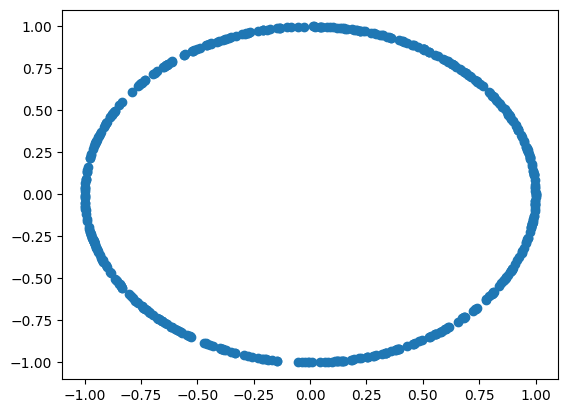

In [12]:
plt.scatter(X.cpu().detach().numpy(), Y.cpu().detach().numpy())

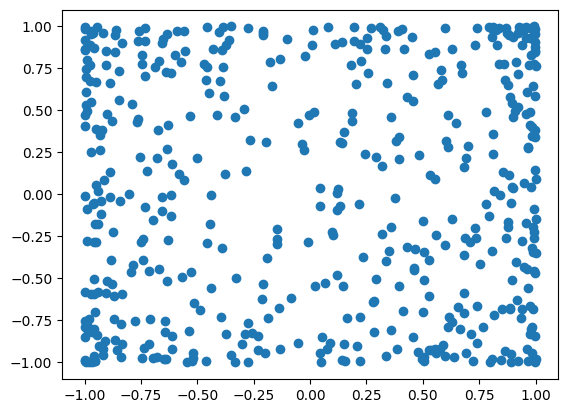

In [13]:
plt.scatter(X_star.cpu().detach().numpy(), Y_star.cpu().detach().numpy())

In [5]:
def make_checkpoint(flow, optimizer, loss, filename):
    torch.save({'model_state_dict': flow.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
               }, 
               filename)

In [6]:
d = 2
num_layers = 5
base_dist = StandardNormal(shape=[d])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=d))
    transforms.append(MaskedAffineAutoregressiveTransform(features=d, 
                                                          hidden_features=8))
transform = CompositeTransform(transforms)

flow_XY = Flow(transform, base_dist)
flow_XY.to(device)
optimizer = optim.Adam(flow_XY.parameters())

In [7]:
# Train flow.
trn_dir = 'betas/'
num_iter = 10000 # Use dataset 10,000 times.
losses = np.zeros(num_iter)

best = np.inf * np.ones(10)
print(-flow_XY.log_prob(inputs=D).mean())
for i in tqdm.trange(num_iter):
    optimizer.zero_grad()
    loss = -flow_XY.log_prob(inputs=D).mean()
    losses[i] = loss
    
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        np.save(trn_dir + 'losses.npy', losses)
        make_checkpoint(flow_XY, optimizer, loss, trn_dir + 'ckpt_{}'.format(i))
        
    if losses[i] < max(best):
        idx = np.argmax(best)
        make_checkpoint(flow_XY, optimizer, loss, trn_dir + 'best/ckpt_{}'.format(idx))
        best[idx] = losses[i]
        np.save(trn_dir + 'best.npy', best)
        
make_checkpoint(flow_XY, optimizer, loss, trn_dir + 'ckpt_{}'.format(num_iter))
np.save(trn_dir + 'losses.npy', losses)

tensor(5.5933, device='cuda:0', grad_fn=<NegBackward0>)


100%|██████████| 10000/10000 [01:53<00:00, 88.25it/s]


In [8]:
d = 1
num_layers = 5
base_dist = StandardNormal(shape=[d])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=d))
    transforms.append(MaskedAffineAutoregressiveTransform(features=d, 
                                                          hidden_features=8))
transform = CompositeTransform(transforms)

flow_X = Flow(transform, base_dist)
flow_X.to(device)
optimizer = optim.Adam(flow_X.parameters())

In [9]:
# Train flow.
trn_dir = 'betas/'
num_iter = 10000 # Use dataset 10,000 times.
losses = np.zeros(num_iter)

best = np.inf * np.ones(10)
print(-flow_X.log_prob(inputs=X).mean())
for i in tqdm.trange(num_iter):
    optimizer.zero_grad()
    loss = -flow_X.log_prob(inputs=X).mean()
    losses[i] = loss
    
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        np.save(trn_dir + 'losses.npy', losses)
        make_checkpoint(flow_X, optimizer, loss, trn_dir + 'ckpt_{}'.format(i))
        
    if losses[i] < max(best):
        idx = np.argmax(best)
        make_checkpoint(flow_X, optimizer, loss, trn_dir + 'best/ckpt_{}'.format(idx))
        best[idx] = losses[i]
        np.save(trn_dir + 'best.npy', best)
        
make_checkpoint(flow_X, optimizer, loss, trn_dir + 'ckpt_{}'.format(num_iter))
np.save(trn_dir + 'losses.npy', losses)

tensor(3.6001, device='cuda:0', grad_fn=<NegBackward0>)


100%|██████████| 10000/10000 [01:36<00:00, 103.74it/s]


In [10]:
d = 1
num_layers = 5
base_dist = StandardNormal(shape=[d])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=d))
    transforms.append(MaskedAffineAutoregressiveTransform(features=d, 
                                                          hidden_features=8))
transform = CompositeTransform(transforms)

flow_Y = Flow(transform, base_dist)
flow_Y.to(device)
optimizer = optim.Adam(flow_Y.parameters())

In [11]:
# Train flow.
trn_dir = 'betas/'
num_iter = 10000 # Use dataset 10,000 times.
losses = np.zeros(num_iter)

best = np.inf * np.ones(10)
print(-flow_Y.log_prob(inputs=Y).mean())
for i in tqdm.trange(num_iter):
    optimizer.zero_grad()
    loss = -flow_Y.log_prob(inputs=Y).mean()
    losses[i] = loss
    
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        np.save(trn_dir + 'losses.npy', losses)
        make_checkpoint(flow_Y, optimizer, loss, trn_dir + 'ckpt_{}'.format(i))
        
    if losses[i] < max(best):
        idx = np.argmax(best)
        make_checkpoint(flow_Y, optimizer, loss, trn_dir + 'best/ckpt_{}'.format(idx))
        best[idx] = losses[i]
        np.save(trn_dir + 'best.npy', best)
        
make_checkpoint(flow_Y, optimizer, loss, trn_dir + 'ckpt_{}'.format(num_iter))
np.save(trn_dir + 'losses.npy', losses)

tensor(2.6505, device='cuda:0', grad_fn=<NegBackward0>)


100%|██████████| 10000/10000 [01:33<00:00, 106.47it/s]


In [15]:
flow_X.eval();

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): ReversePermutation()
      (1): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=1, out_features=8, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedResidualBlock(
              (linear_layers): ModuleList(
                (0-1): 2 x MaskedLinear(in_features=8, out_features=8, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=8, out_features=2, bias=True)
        )
      )
      (2): ReversePermutation()
      (3): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=1, out_features=8, bias=True)
          (blocks): ModuleList(
            (0-1): 2 x MaskedResidualBlock(
              (linear_layers): ModuleList(
                

In [12]:
flow_X.log_prob(X).mean() + flow_Y.log_prob(Y).mean() - flow_XY.log_prob(D).mean()

tensor(-2.3566, device='cuda:0', grad_fn=<SubBackward0>)

In [17]:
np.round(np.linspace(0, 1, 11), 1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [18]:
def make_checkpoint(flow, optimizer, loss, filename):
    torch.save({'model_state_dict': flow.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
               }, 
               filename)

def make_flow(d, num_layers = 5):
    base_dist = StandardNormal(shape=[d])
    
    transforms = []
    for _ in range(num_layers):
        transforms.append(ReversePermutation(features=d))
        transforms.append(MaskedAffineAutoregressiveTransform(features=d, 
                                                              hidden_features=8))
    transform = CompositeTransform(transforms)
    
    return Flow(transform, base_dist)

def train_flow(flow, optimizer, data, dir, num_iter = 10000):
    losses = np.zeros(num_iter)
    print(-flow.log_prob(inputs=data).mean())
    for i in tqdm.trange(num_iter):
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=data).mean()
        losses[i] = loss
        
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            np.save(trn_dir + 'losses.npy', losses)
            make_checkpoint(flow, optimizer, loss, dir + 'ckpt_{}'.format(i))
            
    make_checkpoint(flow, optimizer, loss, dir + 'ckpt_{}'.format(num_iter))
    np.save(dir + 'losses.npy', losses)

In [19]:
np.random.seed(666)
U = stats.uniform.rvs(scale = 2*np.pi, size = n)
R = np.array([[np.cos(α), -np.sin(α)], [np.sin(α), np.cos(α)]])

In [21]:
b = 0.5
a = np.sqrt(2 - a**2)
V = np.vstack([a * np.cos(U), b * np.sin(U)])
D = (R @ V).T

D = torch.tensor(D, dtype = torch.float32).cuda()
X = D[:, 0].reshape(n, 1)
Y = D[:, 1].reshape(n, 1)
D.to(device)
X.to(device)
Y.to(device)

tensor([[-0.5532],
        [ 0.1010],
        [-0.6315],
        ...,
        [-0.3825],
        [ 0.7318],
        [ 0.5262]], device='cuda:0')

In [23]:
import os

In [26]:
flow_XY = make_flow(d = 2)
flow_XY.to(device)
optimizer_XY = optim.Adam(flow_XY.parameters())

os.makedirs('b/{}/XY'.format(b), exist_ok = True)
train_flow(flow_XY, optimizer_XY, D, 'b/{}/XY/'.format(b))

tensor(5.6437, device='cuda:0', grad_fn=<NegBackward0>)


100%|██████████| 10000/10000 [02:15<00:00, 74.02it/s]


In [ ]:
flow_X = make_flow(d = 1)
flow_X.to(device)
optimizer_X = optim.Adam(flow_X.parameters())

os.makedirs('X', exist_ok = True)
train_flow(flow_X, optimizer_X, X, 'X/')

In [27]:
flow_Y = make_flow(d = 1)
flow_Y.to(device)
optimizer_Y = optim.Adam(flow_Y.parameters())

os.makedirs('Y', exist_ok = True)
train_flow(flow_Y, optimizer_Y, Y, 'Y/')

tensor(2.8256, device='cuda:0', grad_fn=<NegBackward0>)


100%|██████████| 10000/10000 [02:16<00:00, 73.17it/s]


In [28]:
S = flow_Y.sample(n)

(array([7.0000e+00, 2.7500e+02, 2.4360e+03, 1.2238e+04, 2.8348e+04,
        3.2660e+04, 1.8285e+04, 5.0300e+03, 6.8000e+02, 4.1000e+01]),
 array([-2.53856611, -2.04922152, -1.55987692, -1.07053232, -0.58118773,
        -0.09184313,  0.39750147,  0.88684607,  1.37619066,  1.86553526,
         2.35487986]),
 <BarContainer object of 10 artists>)

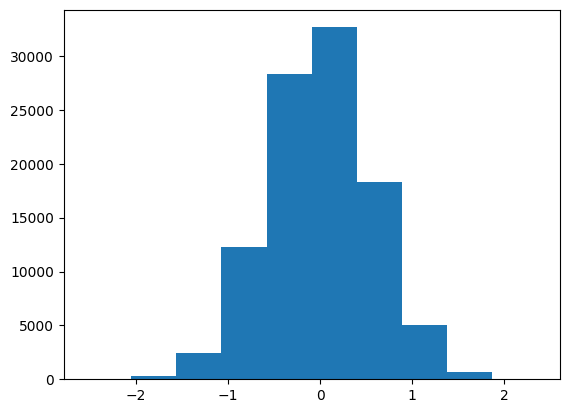

In [30]:
plt.hist(S.cpu().detach().numpy())

(array([20339.,  9123.,  7422.,  6643.,  6471.,  6526.,  6637.,  7220.,
         8876., 20743.]),
 array([-0.79056942, -0.63245553, -0.47434166, -0.31622776, -0.15811388,
         0.        ,  0.15811388,  0.31622776,  0.47434166,  0.63245553,
         0.79056942]),
 <BarContainer object of 10 artists>)

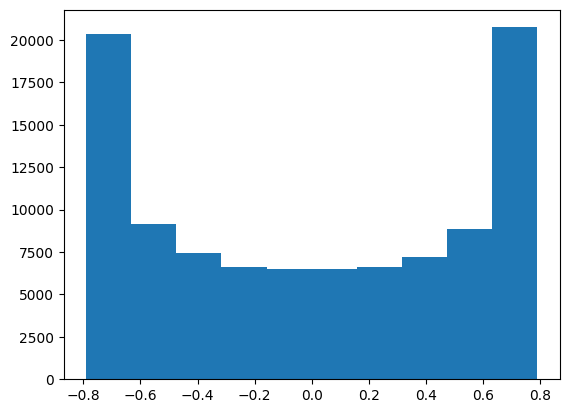

In [32]:
plt.hist(Y.cpu().detach().numpy())